In [2]:
from metrics import *
import argparse
from utils import *
import yaml

In [4]:
path = './config/ST_Gulf_IMLP.yaml'

with open(path, 'r') as f:
    args = yaml.safe_load(f)

In [5]:
train_data, test_data = get_dataset(args)
train_loader, val_loader, test_loader = get_loader(train_data, test_data, args)

Shape of variables: torch.Size([288, 10, 54, 100]) torch.Size([288, 15, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([15])
shape of variable:  torch.Size([1555200, 10]) torch.Size([1555200, 15]) torch.Size([1555200, 10]) torch.Size([1555200, 15]) torch.Size([15])
Shape of variables: torch.Size([25, 10, 54, 100]) torch.Size([25, 15, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([15])
shape of variable:  torch.Size([135000, 10]) torch.Size([135000, 15]) torch.Size([135000, 10]) torch.Size([135000, 15]) torch.Size([15])


In [7]:
print('len(train_loader): ', len(train_loader))
print('len(validate_loader)', len(val_loader))
print('len(test_loader)', len(test_loader))

len(train_loader):  699840
len(validate_loader) 155520
len(test_loader) 135000


In [6]:
data = next(iter(train_loader))
for i in range(len(data)):
    print(data[i].shape)

torch.Size([2, 10])
torch.Size([2, 15])
torch.Size([2, 10])
torch.Size([2, 15])
torch.Size([2, 100])


## dataset

In [2]:
import os
import netCDF4 as nc
import xarray as xr
from pathlib import Path
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_ocean_data(data, i):
    """
    绘制第i个时刻的海洋数据

    参数:
    - data: 海洋数据的三维数组，形状为(112, 120, 280)
    - i: 要绘制的时刻的索引（从0开始）
    
    返回:
    - 绘制的数据图像。
    """
    time_data = data[i, :, :]
    
    plt.figure(figsize=(10, 6))
    
    plt.imshow(time_data, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Data Value')

    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.title(f'Ocean Data at Time Index {i}')

    plt.show()

In [16]:
# input_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/new_data/input_new.nc'
SS_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/mdt_cnes_cls18_global_1.nc'
ST_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label_ST.nc'

# input_ds = xr.open_dataset(input_path)
SS_ds = xr.open_dataset(SS_path)
ST_ds = xr.open_dataset(ST_path)
# print(input_ds)
print(SS_ds)

<xarray.Dataset>
Dimensions:  (time: 313, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    data     (time, lat, lon) float64 ...


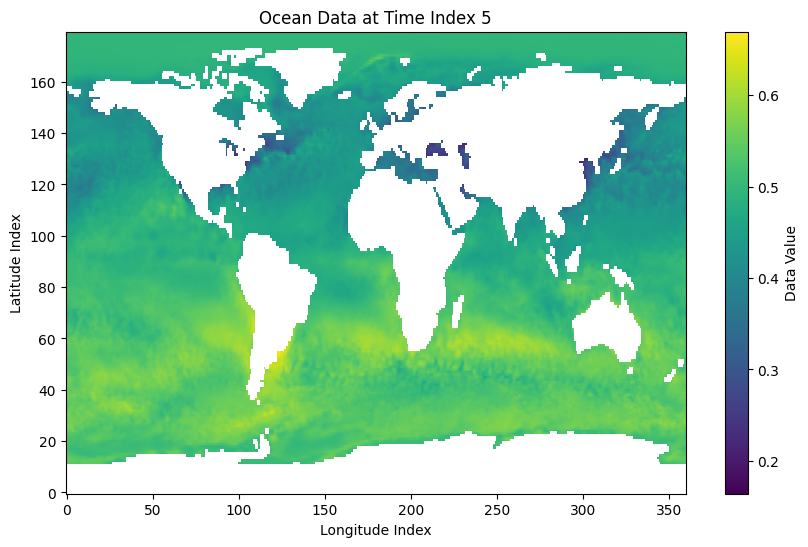

In [12]:
input = input_ds['input'][:]
plot_ocean_data(input[0, ...], 5)

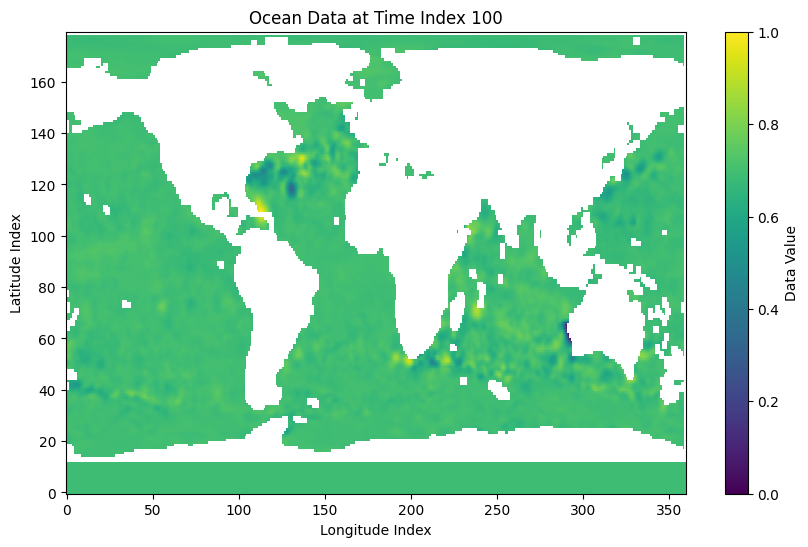

In [57]:
label = ST_ds['label'][:]
plot_ocean_data(label[200, ...], 100)

In [70]:
# 挑选label的深度
path = '/home/data2/pengguohang/My_Ocean/CMEMS/CORA_1993_2019_P1M/CORA_199301_201901_PSAL_P1M.nc'

ds = xr.open_dataset(path)
depth = ds['depth']
print(depth)
my_depth = depth.isel({'depth': [0, 3, 7, 15, 21, 26, 31, 41, 51, 61, 71, 81, 91, 96, 101]})
print(my_depth)

<xarray.DataArray 'depth' (depth: 102)>
array([   1.,    3.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,   90.,
         95.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,  180.,
        190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,  270.,  280.,
        290.,  300.,  310.,  320.,  330.,  340.,  350.,  360.,  370.,  380.,
        390.,  400.,  410.,  420.,  430.,  440.,  450.,  460.,  470.,  480.,
        490.,  500.,  510.,  520.,  530.,  540.,  550.,  560.,  570.,  580.,
        590.,  600.,  610.,  620.,  630.,  640.,  650.,  660.,  670.,  680.,
        690.,  700.,  710.,  720.,  730.,  740.,  750.,  760.,  770.,  780.,
        790.,  800.,  820.,  840.,  860.,  880.,  900.,  920.,  940.,  960.,
        980., 1000.], dtype=float32)
Coordinates:
  * depth    (depth) float32 1.0 3.0 5.0 10.0 15.0 ... 940.0 960.0 980.0 1e+03
Attributes:
    axis:           Z
    long_name:      Depth
 

In [ ]:
import h5py
import numpy as np
import os
import torch
from torch.utils.data import Dataset
import xarray as xr
from netCDF4 import Dataset as dataset_net

class STDataset(Dataset):
    def __init__(self,
                 folder_path='/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/new_data',
                 label_path='/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/label.nc',
                 task='S',  # S T Chl 
                 if_train=True,
                 seq_len=5,
                 ):

        if task == 'T':
            file_path = 'label_T_new.nc'
        elif task == 'S':
            file_path = 'label_S_new.nc'

        self.input, self.label = self.get_data(folder_path, file_path)
        self.lat, self.lon, self.depth = self.get_label(label_path)

        self.input = torch.tensor(self.input).permute(0, 1, 2, 3)  # Converts numpy to PyTorch tensor
        self.label = torch.tensor(self.label).permute(0, 1, 2, 3)
        self.lat = torch.tensor(self.lat.values)
        self.lon = torch.tensor(self.lon.values)
        self.depth = torch.tensor(self.depth.values)

        # Create mask: if any input variable or label at a grid point is NaN, set mask to False
        input_nan_mask = torch.isnan(self.input)
        label_nan_mask = torch.isnan(self.label)
        input_nan_mask = input_nan_mask.any(dim=(0, 1))  # [time, var, lat, lon]
        label_nan_mask = label_nan_mask.any(dim=(0, 1))
        self.mask = (~label_nan_mask) & (~input_nan_mask)  # [lat, lon], NaNs are False

        # Time-series data: Add seq_len dimension, create sliding window sequences
        if seq_len > 0:
            num = self.input.shape[0] - seq_len
            self.input = torch.stack([self.input[i:i + seq_len] for i in range(num)], dim=0)
            self.label = torch.stack([self.label[i + seq_len - 1:i + seq_len] for i in range(num)], dim=0)

        # Split data into train: 199401-201712, test: 199301-199312, 201801-201901
        test_len = 12
        train_len = self.input.shape[0] - test_len
        if if_train:
            self.input = self.input[test_len + 1:train_len, ...]
            self.label = self.label[test_len + 1:train_len, ...]
        else:
            input1 = self.input[:test_len + 1, ...]  # First 12 months
            label1 = self.label[:test_len + 1, ...]
            input2 = self.input[train_len:, ...]  # Last 12 months
            label2 = self.label[train_len:, ...]
            self.input = torch.cat((input1, input2), dim=0)
            self.label = torch.cat((label1, label2), dim=0)

        print('Shape of variables:', self.input.shape, self.label.shape, self.lat.shape, self.lon.shape, self.depth.shape)

    def get_data(self, folder_path, file_path):
        """
        Extract input data and concatenate
        folder_path: data folder path

        return: (var, time, lat, lon)
        """
        input_path = os.path.join(folder_path, 'input_new.nc')
        label_path = os.path.join(folder_path, file_path)
        input = xr.open_dataset(input_path)
        label = xr.open_dataset(label_path)

        return input['input'].values, label['label'].values
    
    def get_label(self, path):
        """
        Extract lat, lon, and depth from label
        """
        f = xr.open_dataset(path)
        depth = f['depth']
        lat = f['latitude']
        lon = f['longitude']
        
        return lat, lon, depth

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        inputs = self.input[idx]   # (var, lat, lon) or (seq, var, lat, lon)
        label = self.label[idx]    # (dept, lat, lon) or (seq, dept, lat, lon)
        lat = self.lat
        lon = self.lon
        depth = self.depth
        mask = self.mask  # (lat, lon)
        
        return inputs.float(), label.float(), mask, lat, lon, depth


## 数据


In [3]:
import os
import shutil

# 定义根目录
root_dir = '/home/data2/pengguohang/My_Ocean/CCMP/v02.0_1993_2013'
target_dir = '/home/data2/pengguohang/My_Ocean/CCMP/new_M/'
# print(os.listdir(root_dir))
# for subdir, dirs, files in os.walk(root_dir):
    # print('path: ', files)
# 遍历根目录下的所有子目录
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        # 检查文件名是否以'L3.5_RSS.nc'结尾
        if file.endswith('L3.5_RSS.nc'):
            # 构建完整的文件路径
            file_path = os.path.join(subdir, file)
            # 构建目标路径（根目录）
            target_path = os.path.join(target_dir, file)
            # 复制文件
            shutil.copy(file_path, target_path)
            print(f'Copied {file_path} to {target_path}')

FileNotFoundError: [Errno 2] No such file or directory: '/home/data2/pengguohang/My_Ocean/CCMP/new_M/CCMP_Wind_Analysis_climatology_V02.0_L3.5_RSS.nc'

In [ ]:
import h5py
import numpy as np
import os
import torch
from torch.utils.data import Dataset, IterableDataset
import xarray as xr
import torch.nn.functional as F

# 数据归一化问题
# 输入数据处理：基于reference_file插值
# 

class STDataset(Dataset):
    def __init__(self,
                 region_name = 'Gulf',
                 folder_path='../data/',
                 reference_file = '/home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc', 
                 label_path = '../',
                 lat_min = 23,
                 lat_max = 50, 
                 lon_min = -80,
                 lon_max = -30,
                 challenge = 'ST',
                 add_time = False,
                 if_train = True,
                 seq_len = 0,
                 ):
        '''
        Args:
            region_name(str) : 提取的数据范围(Gulf )
            folder_path(str) : 存放所有数据的文件夹 , "/home/data2/pengguohang/My_Ocean/challenge"
            reference_file(str): 数据处理时的参考文件(参考mask 分辨率等)
            lat_min, lat_max(int) : 纬度范围
            lon_min, lon_max(int) : 经度范围
            key(str) : SS(so), ST(st)
        Returns:
            input, label, lat, lon, depth
        shape:
            (var, month, lat, lon), (depth, month, lat, lon), (x, y, p), (x, y, 2), (36)

            lat_min, lat_max, lon_min, lon_max, data, latitude, longitude
        '''
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.lon_min = lon_min
        self.lon_max = lon_max

        if challenge == 'ST':
            key = 'to'
        elif challenge == 'SS':
            key = 'so'

        # 提取数据
        self.input, self.mask = self.get_input_data(folder_path, reference_file)
        self.label, self.lat, self.lon, self.depth= self.get_armor(label_path, key)
        
        self.input = torch.from_numpy(self.input.values).permute(1,0,2,3)
        self.label = torch.from_numpy(self.label.values).permute(1,0,2,3)
        self.lat = torch.from_numpy(self.lat.values)
        self.lon = torch.from_numpy(self.lon.values)
        self.depth = torch.from_numpy(self.depth.values)

        # 将lat和lon合并到input中
        time = self.input.shape[0]
        lat = self.input.shape[2]
        lon = self.input.shape[3]
        expand_lat = self.lat.unsqueeze(0).unsqueeze(-1).repeat(time, 1, 1, lon)
        expand_lon = self.lon.unsqueeze(0).unsqueeze(0).repeat(time, 1, lat, 1)
        self.input = torch.cat((self.input, expand_lat, expand_lon), dim=1)

        # 将时间合并到input中
        if add_time:
            ds = xr.open_dataset(reference_file)
            time = ds.variables['time'][0:109].values  # 201001 - 201901
            jd1 = torch.cos( torch.tensor(2*np.pi*(time/12)+1) )
            jd2 = torch.sin( torch.tensor(2*np.pi*(time/12)+1) )
            jd1 = jd1.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
            jd2 = jd2.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
            # print('jd1, jd2', jd1.shape, jd2.shape)
            self.input = torch.cat((self.input, jd1), dim=1)
            self.input = torch.cat((self.input, jd2), dim=1)

        # LSTM数据：增加seq_len维度
        test_len = 10  # 从train中随机拿出10个月份的数据作为验证集
        if seq_len > 0:
            num = self.input.shape[0] / seq_len
            var = self.input.shape[1]
            depth = self.label.shape[1]

            self.input = self.input[0:int(num)*seq_len, ...].reshape(int(num), seq_len, var, lat, lon)
            self.label = self.label[0:int(num)*seq_len, ...].reshape(int(num), seq_len, depth, lat, lon)

            test_len = int(np.ceil(10 / seq_len))
        #  torch.Size([109, 12, 108, 200]) torch.Size([109, 36, 108, 200])
        
        # 将数据中的nan全换为0
        self.input = torch.where(torch.isnan(self.input), torch.full_like(self.input, 0), self.input)
        self.label = torch.where(torch.isnan(self.label), torch.full_like(self.label, 0), self.label)

        # 总数据：0:109, 代表201001-201901
        # 数据划分为train:201001-201806 test:201807-201901
        # 从train中随机拿出10个月份的数据作为验证集
        train_len = self.input.shape[0] - test_len
        # print(train_len, test_len)
        if if_train:
            self.input = self.input[0:train_len, ...]
            self.label = self.label[0:train_len, ...]
        else:
            self.input = self.input[train_len:, ...]
            self.label = self.label[train_len:, ...]
        
        
        print('shape of variable: ', self.input.shape, self.label.shape, self.lat.shape, self.lon.shape, self.depth.shape)

    def get_sub(self, data, latitude, longitude):
        """
        提取子区域的数据

        input:
        lat_min, lat_max, lon_min, lon_max: 子区域范围
        data: 原始数据
        latitude, longitude: 经纬度数据

        return: subset_data, subset_lat, subset_lon
        """
        # 找到对应的索引
        lat_indices = np.where((latitude >= self.lat_min) & (latitude <= self.lat_max))[0]
        lon_indices = np.where((longitude >= self.lon_min) & (longitude <= self.lon_max))[0]
        # 提取子集数据
        subset_data = data[:, lat_indices, :][:, :, lon_indices]
        # 提取相应的经纬度数组
        subset_lat = latitude[lat_indices]
        subset_lon = longitude[lon_indices]

        return subset_data, subset_lat, subset_lon


    def compute_climatological_mean_and_anomalies(self, data):
        """
        计算每个变量的气候学平均值, 从而计算其异常值
        input: data (xarray.Dataset or xarray.DataArray): 包含多个变量的时间序列数据，维度为 (time, lat, lon)。
        return: xarray.Dataset or xarray.DataArray: 包含异常值的数据集，维度为 (time, lat, lon)。
        """
        # 时间维度名为 'time'
        # print("Dimensions of data:", data.dims)
        
        # 计算气候学平均值（沿着time维度求平均）
        clim_mean = data.mean(dim='time')
        
        # 扩展气候学平均值，使其具有与原始数据相同的 time 维度
        clim_mean_expanded = clim_mean.broadcast_like(data)
        
        # 从原始数据中减去气候学平均值得到异常值
        anomalies = data - clim_mean_expanded
        
        return anomalies


    def min_max(self, data):
        """
        对输入数据按变量进行归一化

        input:(var, time, lat, lon)
        output: (var, time, lat, lon)
        """
        minmax = []
        for i in range(data.shape[0]):
            var_data = data[i]
            var_min = var_data.min(dim='time')
            var_max = var_data.max(dim='time')
            normalized_var_data = (var_data - var_min) / (var_max - var_min)
            minmax.append(normalized_var_data)
            # normalized_data.loc[dict(var=var)] = normalized_var_data

        minmax = xr.concat(minmax, dim='file')
        return minmax


    def get_input_data(self, folder_path, reference_file):
        """
        提取输入数据并裁剪
        folder_path, reference_file: 数据文件夹地址 及 参考数据文件地址
        
        return:  (var, time, lat, lon)
        """
        # 1、提取文件名
        nc_files = [file for file in os.listdir(folder_path) if file.endswith('.nc')]
        # 存储数据
        data_all = []

        # 2、先加载reference data, 作为网格插值的基准
        ref_ds = xr.open_dataset(reference_file)
        ref_lat = ref_ds['lat']
        ref_lon = ref_ds['lon']
        ref_data = ref_ds['data'][0:109, ...]   # torch.Size([109, 108, 200])
        # 0.25*0.25下采样到0.5*0.5
        data, sub_ref_lat, sub_ref_lon = self.down_sample(ref_data, ref_lat, ref_lon)
        sub_ref_data = xr.DataArray(data.squeeze(0), dims=["time", "lat", "lon"], coords={"lat": sub_ref_lat, "lon": sub_ref_lon})
        # 提取子区域
        ref_subset_data, ref_subset_lat, ref_subset_lon = self.get_sub(sub_ref_data, sub_ref_lat, sub_ref_lon)
        # print('ref sub: ', ref_subset_data.shape, ref_data.shape)
        # 将 -999.0 的值转换为 np.nan
        mask = np.where(ref_subset_data == -999.0, np.nan, ref_subset_data)
        ref_subset_data = xr.DataArray(mask, dims=["time", "lat", "lon"], coords={"lat": ref_subset_lat, "lon": ref_subset_lon})
        data_all.append(ref_subset_data)

        # 3、逐个加载.nc文件并进行插值
        for file in nc_files:
            file_path = os.path.join(folder_path, file)
            print(f"Processing file: {file_path}")
            # 提取前109个时间步的数据
            ds = xr.open_dataset(file_path)
            data = ds['data'][:109, ...]  
            # 将 'data' 插值到目标经纬度网格
            interpolated_data = data.interp(lat=ref_lat, lon=ref_lon)
            # 0.25*0.25下采样到0.5*0.5
            data, lat, lon = self.down_sample(interpolated_data, ref_lat, ref_lon)
            data = xr.DataArray(data.squeeze(0), dims=["time", "lat", "lon"], coords={"lat": lat, "lon": lon})
            # print('after sample: ', data.shape, lat.shape, lon.shape)
            # 提取子区域
            subset_data, subset_lat, subset_lon = self.get_sub(data, lat, lon)
            # print('sub_set: ', subset_data.shape, subset_lat.shape, subset_lon.shape)
            # 掩码处理：通过reference的nan值将所有数据相同位置的数字换为nan
            nan_mask = np.isnan(ref_subset_data)
            # print('mask: ', nan_mask.shape)
            # print(nan_mask)
            masked_data = np.where(nan_mask, np.nan, subset_data)
            masked_data = xr.DataArray(masked_data, dims=["time", "lat", "lon"], coords={"lat": ref_subset_lat, "lon": ref_subset_lon})
            
            data_all.append(masked_data)


        # 将所有插值后的数据堆叠在一起
        data_all = xr.concat(data_all, dim='file')
        # 将数据中绝对值大于100的数值替换为NaN
        data_all = data_all.where(np.abs(data_all) <= 100, np.nan)
        # 计算数据异常值 - 减去 climatological mean
        data_all = self.compute_climatological_mean_and_anomalies(data_all)
        # 最大最小归一化
        data_all = self.min_max(data_all)

        # print('shape of region:', data_all.shape)
        return data_all, nan_mask  # mask: (109, 54, 100)


    def down_sample(self, data, lat_list, lon_list):
        '''
        0.25*0.25下采样到0.5*0.5

        in: (t, lat, lon)
        out: DataArray dim=(t, lat, lon)
        '''
        data = torch.tensor(data.values)  # array --> tensor
        if data.dim() == 3:
            data = data.unsqueeze(0)

        lat, lon = data.shape[-2], data.shape[-1]
        new_lat, new_lon = int(lat / 2), int(lon / 2)  # 目标尺寸
        new_size = (new_lat, new_lon)

        data = F.interpolate(data, size=new_size, mode='bilinear', align_corners=False)

        return data, lat_list[::2], lon_list[::2]
    
    
    def get_armor(self, path, key):
        '''
        提取label

        armor数据如下:
        depth (36,)
        latitude (688,)
        longitude (1439,)
        time (313,)
        mlotst (313, 688, 1439)
        so (313, 36, 688, 1439)
        to (313, 36, 688, 1439)
        
        return: (depth, time, lat, lon)
        '''
        f = xr.open_dataset(path, chunks={'time': 1})
        data = f[key][204:313, ...]
        depth = f['depth']
        lat = f['latitude']
        lon = f['longitude']

        # down_sample
        sub_data, lat, lon = self.down_sample(data, lat, lon)
        print('in armor: ', sub_data.shape, lat.shape, lon[:719].shape)
        # data = xr.DataArray(sub_data, dims=["time", "depth", "lat", "lon"], coords={"lat": lat, "lon": lon[:719]})
        data = xr.DataArray(
    sub_data,
    dims=["time", "depth", "latitude", "longitude"],
    coords={"latitude": lat, "longitude": lon[:719]}
)
        print('in armor: ', data.shape, lat.shape, lon.shape)
        # print('begin:', data.shape)
        # 找到对应的索引
        lat_indices = np.where((lat >= self.lat_min) & (lat <= self.lat_max))[0]
        lon_indices = np.where((lon >= self.lon_min) & (lon <= self.lon_max))[0]
        # print('lat,lon:', lat_indices.shape, lon_indices.shape)

        # 提取子集数据
        subset_data = data[:, :, lat_indices, lon_indices].transpose('depth', 'time',  'latitude', 'longitude')
        # print('end:', subset_data.shape)

        # 提取相应的经纬度数组
        subset_lat = lat[lat_indices]
        subset_lon = lon[lon_indices]

        # 计算数据异常值 - 减去 climatological mean
        # print(subset_data.dims)
        subset_data = self.compute_climatological_mean_and_anomalies(subset_data)

        # minmax归一化
        subset_data = self.min_max(subset_data)

        # print('return:', subset_data.shape)

        return subset_data, subset_lat, subset_lon, depth
    

    def __len__(self):
        return len(self.input)


    def __getitem__(self, idx):
        inputs = self.input[idx]   # (var, lat, lon) or (seq, var, lat, lon)
        label = self.label[idx]    # (dept, lat, lon) or (seq, dept, lat, lon)
        lat = self.lat
        lon = self.lon
        depth = self.depth
        mask = torch.tensor(self.mask[0, 0, ...].values)  # (1, t, lat ,lon)  ->  (lat, lon)
        
        return inputs.float() , label.float() , mask, lat, lon

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
in armor:  torch.Size([109, 36, 344, 719]) (344,) (719,)
in armor:  (109, 36, 344, 719) (344,) (720,)
shape of variable:  torch.Size([99, 12, 54, 100]) torch.Size([99, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])


## model

In [15]:
import os
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import orjson
import matplotlib.pyplot as plt
import yaml


from model import *
from utils import get_dataset, get_loader, get_model, train_model, test_model
from dataset import *


lat = torch.rand(180, 1)
lon = torch.rand(360, 1)
sst = torch.rand(64, 1)
data = torch.rand(8192, 1)

batch_size = 10
num_features = 4
# x: [bs, 5]
x = torch.cat([
    lat[:batch_size],
    lon[:batch_size],
    sst[:batch_size],
    data[:batch_size]
], dim=1)
print(x.shape)

embedding_lat = nn.Embedding(180, 16)
y = torch.cat((embedding_lat(torch.trunc(x[:, 0]).long()), torch.frac(x[:, 0]).unsqueeze(1)), 1)
print(y.shape)

torch.Size([10, 4])
torch.Size([10, 17])


In [16]:


config_file = './config/ST_Gulf_FNN.yaml'
with open(config_file, 'r') as f:
    args = yaml.safe_load(f)

dataset = args['dataset']
train_dataset = STDataset_points(
                 region_name = dataset['region_name'],
                 folder_path= dataset['folder_path'],
                 reference_file = dataset['reference_file'], 
                 label_path = dataset['label_path'],
                 lat_min = dataset['lat_min'],
                 lat_max = dataset['lat_max'], 
                 lon_min = dataset['lon_min'],
                 lon_max = dataset['lon_max'],
                 challenge = args['challenge_name'],
                 add_time = True, 
                 if_train=True,
                 seq_len=dataset['seq_len']
                 )

Processing file: /home/data2/pengguohang/My_Ocean/challenge/vwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sss_cci_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/swh_monthly_201001_201912_data.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/oisst_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/uwnd_monthly_201001-201904.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/sla_monthly_201001_201901.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/adt_monthly_201001-201912.nc
shape of variable:  torch.Size([99, 13, 54, 100]) torch.Size([99, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
shape of variable:  torch.Size([534600, 13]) torch.Size([534600, 36]) torch.Size([54]) torch.Size([100]) torch.Size([36])


In [18]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for inputs, targets, mask, lat, lon in train_loader:
    print(inputs, targets.shape)

    break

tensor([[ 6.4922e-01,  6.1435e-01,  2.3715e-01,  2.9902e-02,  6.4922e-01,
          4.4727e-01,  1.2597e-01,  1.2704e-01,  2.7625e+01, -4.9625e+01,
         -5.4030e-01, -8.4147e-01,  1.0000e+00]]) torch.Size([1, 36])


In [7]:
import torch.nn as nn
import torch

class Attention(nn.Module):
    def __init__(self, input_size, hidden_size, depth):
        super(Attention, self).__init__()
        self.query_linear = nn.Linear(input_size, hidden_size)
        self.key_linear = nn.Linear(input_size, hidden_size)
        self.value_linear = nn.Linear(input_size, hidden_size)
        self.softmax = nn.Softmax(dim=-1)
        self.depth_linear = nn.Linear(hidden_size, depth)
    def forward(self, query, keys, values):
        query = self.query_linear(query)
        keys = self.key_linear(keys)
        values = self.value_linear(values)
        scores = torch.matmul(query, keys.transpose(-2, -1))
        scores = self.softmax(scores)
        attended_values = torch.matmul(scores, values)
        output = self.depth_linear(attended_values)
        return output

class AT_GRU(nn.Module):
    def __init__(self, num_layers, rnn_hidden_size, encoder_input_size, encoder_hidden_size, depth=36):
        super(AT_GRU, self).__init__()
        self.depth = depth
        self.num_layers = num_layers
        self.rnn_hidden_size = rnn_hidden_size
        self.embedding_lat = nn.Embedding(180, 16)
        self.embedding_lon = nn.Embedding(360, 16)
        self.embedding_sst = nn.Embedding(64, 16)
        self.embedding_date = nn.Embedding(8192, 16)
        self.attention = Attention(encoder_input_size, encoder_hidden_size, depth)
        self.line = nn.Linear(16 * 4 + 4, depth)
        self.dropout = nn.Dropout(p=0.1 )
        self.bi_gru = nn.GRU(input_size=1, hidden_size=rnn_hidden_size,num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(rnn_hidden_size * 2 * depth, depth)
        self.flatten = nn.Flatten(1, -1)

    def forward(self, x):
        # x: [bs, 5]
        # embedding - 张量拼接
        x0 = torch.cat((self.embedding_lat(torch.trunc(x[:, 0]).long()), torch.frac(x[:, 0]).unsqueeze(1)), 1)
        x1 = torch.cat((self.embedding_lon(torch.trunc(x[:, 1]).long()), torch.frac(x[:, 1]).unsqueeze(1)), 1)
        x2 = self.embedding_date(x[:, 2].long())
        x3 = torch.cat((self.embedding_sst(torch.trunc(x[:, 3]).long()), torch.frac(x[:, 3]).unsqueeze(1)), 1)
        x = torch.cat((x0, x1, x2, x3, x[:, -1].unsqueeze(1)), 1)  # [bs, 68]
        # self-attention
        attention_output = self.attention(x.float(), x.float(), x.float())
        # res
        x = x.to(torch.float32)
        x = self.line(x)
        x = x + attention_output
        x = self.dropout(x)
        # gru
        output, h = self.bi_gru(x.unsqueeze(-1))
        # output
        output = self.flatten(output)
        output = self.fc(output)
        return output
    
    def train_one_step(self, x, y, mask, criterion, k, metric_names={}):
        '''
        x:      [bs, var+1]
        y:      [bs, depth]
        mask:   [1]
        pred:   [bs, depth]

        return: loss
        '''
        # process data
        info = {}
        bs_1, var = x.shape[0], x.shape[1]
        bs_2, depth = y.shape
        train_x = x[:, 0:var]  # (bs, var)
        mask = x[0, -1].unsqueeze(0).repeat(bs_2, k)  # (bs, k)

        y = y[:, 0:k]*mask
        
        pred = self(train_x)  # (bs, n)

        print('pred, y: ', pred.shape, y.shape, mask.shape, train_x.shape)
        
        if metric_names:
            pred = pred[:, 0:k]
            pred = pred * mask
            # print('pred, y: ', pred.shape, y.shape)
            loss = criterion(pred, y, metric_names)
        else:
            pred = pred[:, 0:k]
            pred = pred * mask
            loss = criterion(pred, y)

        return loss, pred, info

In [8]:
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
for inputs, targets, mask, lat, lon in train_loader:
    print(inputs.shape, targets.shape)

    break

model = AT_GRU( num_layers=1, rnn_hidden_size=5, encoder_input_size=68, encoder_hidden_size=512, depth=36)
# print(inputs.shape)
# outputs = model(inputs)
# print(outputs.shape)
# model(inputs[:, 0, :])

loss, pred, info = model.train_one_step(x, y, mask, criterion = nn.MSELoss(), k=10, metric_names={})
print(loss)

torch.Size([5, 13]) torch.Size([5, 36])
pred, y:  torch.Size([10, 36]) torch.Size([10, 10]) torch.Size([10, 10]) torch.Size([10, 4])
tensor(0.0038, grad_fn=<MseLossBackward0>)


In [14]:
a = True
b = not a
b

False